In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import HTC
import time
from scipy import signal

In [3]:
# Load connectome and normalize it
W=np.loadtxt("../Data/connectivity_matrix/weights.txt")
W=W/W.sum(axis=1)[:,None]

In [4]:
# Create brain object and set its parameters
brain=HTC.Brain(W)
n_neurons=brain.n_neurons
brain.set_netowrk_parameters(r1=2/n_neurons, r2=(2/n_neurons)**0.2, tc=0.15)

In [5]:
active_frac=0.1 #Initial fraction of active neurons
n_runs=50 #Parallel runs
tmin=0.01 #Min tc
tmax=0.3 #Max tc
delta_tc=0.01 #Variation of tc
dt=0.1 #Time step
n_timesteps=600 #Total number of timesteps
s_step=10 #Campute s1 s2 every s_step (to speed up computing time)
compute_s1_s2=False 
compute_s_distrib=False
compute_fc=True

In [6]:
%%time
output=brain.simulation(active_frac=active_frac, n_runs=n_runs,
                      tmin=tmin, tmax=tmax, delta_tc=delta_tc,
                      dt=dt, n_timesteps=n_timesteps,
                      compute_s1_s2=compute_s1_s2, s_step=s_step,
                      compute_s_distrib=compute_s_distrib, tc_distrib=0.15,
                      compute_fc=compute_fc)

CPU times: user 12.2 s, sys: 204 ms, total: 12.4 s
Wall time: 12.4 s


In [7]:
tc=output['tc']
a=output['activity']
sigma_a=output['sigma_activity']
fc=output['fc']

In [8]:
# Load data from specific subject
# Choose to read both blocks or not
def fmri_signal(subject=1, all_blocks=False):
    if all_blocks==True:
        a=np.loadtxt("../Data/fMRI/subj"+str(subject)+"_block1.txt")
        b=np.loadtxt("../Data/fMRI/subj"+str(subject)+"_block2.txt")
        return np.concatenate((a,b))
    elif all_blocks==False:
        a=np.loadtxt("../Data/fMRI/subj"+str(subject)+"_block1.txt")
        return a

#Compute FC for all subjects
correlations=np.zeros((24,66,66), dtype=np.float64)
for subj in range(1,25,1):
    correlations[subj-1]=np.corrcoef(fmri_signal(subj, all_blocks=True), rowvar=False)

#Take the mean of all 24 FC matrix
corr=np.mean(correlations, axis=0)

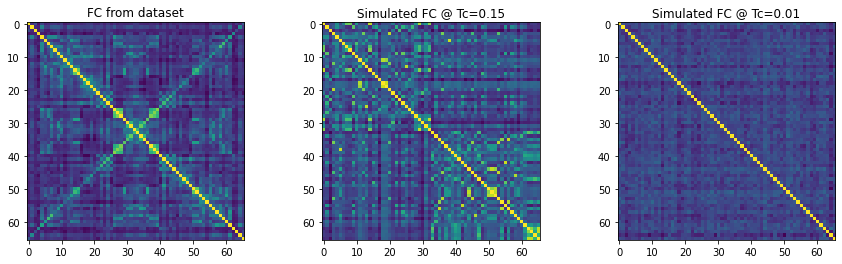

In [9]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.imshow(corr)
plt.title('FC from dataset')

plt.subplot(1,3,2)
plt.imshow(fc[14])
plt.title('Simulated FC @ Tc=%.2f'%tc[14])

plt.subplot(1,3,3)
plt.imshow(fc[0])
plt.title('Simulated FC @ Tc=%.2f'%tc[0])

plt.show()

In [10]:
#Compute rho for all matrices af in Fig 2(a) Rocha
rho=np.zeros_like(tc)
for i in range(len(tc)):
    rho[i]=np.corrcoef(fc[i].flatten(),corr.flatten())[1,0]

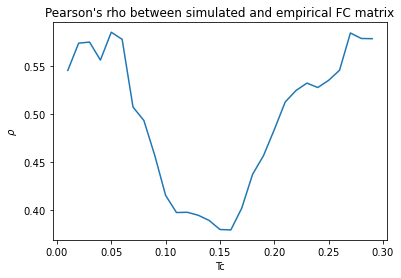

In [11]:
plt.plot(tc,rho)
plt.title("Pearson's rho between simulated and empirical FC matrix")
plt.xlabel('Tc')
plt.ylabel(r'$\rho$')
plt.show()